In [1]:
import os
import sys
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
import pprint
%matplotlib inline

In [2]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

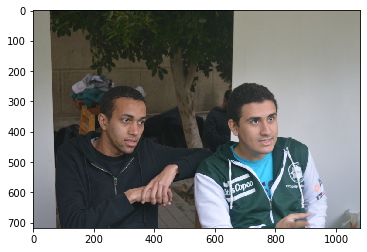

In [3]:
content_path = "images/content.jpg"
style_path = "images/style.jpg"

content_img = mpimg.imread(content_path)
imshow(content_img)

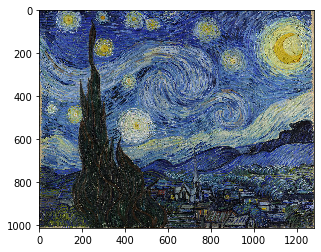

In [4]:
style_img = mpimg.imread(style_path)
imshow(style_img)

In [5]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.transpose(tf.reshape(a_C, [n_H*n_W, n_C]))
    a_G_unrolled = tf.transpose(tf.reshape(a_G, [n_H*n_W, n_C]))
    
    # compute the cost with tensorflow (≈1 line)
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C, a_G)) / (4*n_H*n_W*n_C))
    
    return J_content

In [6]:
def gram_matrix(A):
    return tf.matmul(A, A, transpose_b=True)

In [7]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    a_S = tf.transpose(tf.reshape(a_S, [n_H*n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, [n_H*n_W, n_C]))

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss (≈1 line)
    J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GS, GG))) / (4 * n_C **2 * (n_H * n_W) **2)
    
    return J_style_layer

In [8]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)
]
CONTENT_LAYERS = [
    ('block4_conv2', 1)
]

In [9]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

In [10]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
     return alpha * J_content + beta * J_style

In [19]:
sess = tf.compat.v1.InteractiveSession()

In [13]:
content_image = mpimg.imread(content_path)
content_image = tf.keras.applications.vgg19.preprocess_input(content_image)

In [14]:
style_image = mpimg.imread(style_path)
style_image = tf.keras.applications.vgg19.preprocess_input(style_image)

In [15]:
outputs = [coef * vgg.get_layer(name).output for (name, coef) in STYLE_LAYERS + CONTENT_LAYERS]
model = tf.keras.Model([vgg.input], outputs)


In [29]:
J_style = compute_style_cost(model, STYLE_LAYERS)

tf.Tensor(0.0, shape=(), dtype=float32)


[1, 89, 135, 512]
